## Model Exercises - Based on Walkthrough
`Corey Solitaire`   
10.30.2020   

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Wrangle:

In [3]:
# Call CSV
df = pd.read_csv('time_series_project.csv')
# Convert to Datetime
df.date = pd.to_datetime(df.date)
# Reset Index
df = df.set_index('date').sort_index()
df = df.dropna()

In [4]:
df.head()

calories_burned   steps  distance  floors  mins_sedentary  \
date                                                                    
2018-04-26           2635.0  2931.0      1.38     2.0          1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0          1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0           702.0   
2018-04-29           2851.0  1639.0      0.77     0.0           891.0   
2018-04-30           2825.0  1323.0      0.62     0.0           880.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-04-26               93.0                 0.0               0.0   
2018-04-27              219.0                46.0              17.0   
2018-04-28              155.0                22.0              11.0   
2018-04-29              122.0                 0.0               0.0   
2018-04-30              104.0                 0.0               0.0   

            activity_calories  
date                           
2018-04-26              566.0  
2018-04-27             1752.0  
2018-04-28             1124.0  
2018-04-29              602.0  
2018-04-30              540.0

In [5]:
df.tail()

calories_burned    steps  distance  floors  mins_sedentary  \
date                                                                     
2018-12-02           3957.0  13257.0      6.23   195.0           725.0   
2018-12-03           3660.0  12915.0      6.12     6.0           782.0   
2018-12-04           3384.0  13763.0      6.49    13.0           608.0   
2018-12-05           3670.0  13865.0      6.52    12.0           739.0   
2018-12-06           3669.0  14774.0      6.96     9.0           647.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-12-02              265.0                13.0              70.0   
2018-12-03              219.0                40.0              51.0   
2018-12-04              199.0                11.0              67.0   
2018-12-05              200.0                12.0              69.0   
2018-12-06              198.0                 4.0              78.0   

            activity_calories  
date                           
2018-12-02             2305.0  
2018-12-03             1993.0  
2018-12-04             1663.0  
2018-12-05             1968.0  
2018-12-06             1962.0

In [6]:
df.shape

(225, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   calories_burned     225 non-null    float64
 1   steps               225 non-null    float64
 2   distance            225 non-null    float64
 3   floors              225 non-null    float64
 4   mins_sedentary      225 non-null    float64
 5   mins_light_active   225 non-null    float64
 6   mins_fairly_active  225 non-null    float64
 7   mins_very_active    225 non-null    float64
 8   activity_calories   225 non-null    float64
dtypes: float64(9)
memory usage: 17.6 KB


<div class="alert alert-block alert-info"><b></b></div>

# Explore:

Split:

    1. We will use the training proprtion method to split
    2. Identify lenght of df, mult by train_prop to get the number of rows. x = train_prop * 100
    3. Select row indicies
    4. Return train and test dataframes

<div class="alert alert-block alert-info"><b></b></div>

In [8]:
train_size = int(len(df)*.5)
train_size

112

In [9]:
validate_size = int(len(df)*.3)
validate_size

67

In [10]:
test_size = int(len(df) - train_size - validate_size)
test_size

46

In [11]:
# Verify all data is accounted for
validate_end_index = train_size + validate_size
validate_end_index

179

#### Use Values to Split Data Frame

In [12]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

#### Verify Splits

**Does the length of each df equate to the length of the original df?**

In [13]:
print(len(train) + len(validate) + len(test) == len(df))

True


**Does the first row of original df equate to the first row of train?**


In [14]:
print(df.head(1) == train.head(1))

            calories_burned  steps  distance  floors  mins_sedentary  \
date                                                                   
2018-04-26             True   True      True    True            True   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-04-26               True                True              True   

            activity_calories  
date                           
2018-04-26               True  


**Is the last row of train the day before the first row of validate? And the same for validate to test?**

In [15]:
pd.concat([train.tail(1), validate.head(1)])

calories_burned    steps  distance  floors  mins_sedentary  \
date                                                                     
2018-08-15           4079.0  12259.0      5.78     8.0           704.0   
2018-08-16           3490.0   8039.0      3.79    18.0           877.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-08-15              213.0                23.0              56.0   
2018-08-16              311.0                 7.0               6.0   

            activity_calories  
date                           
2018-08-15             2158.0  
2018-08-16             1678.0

In [16]:
pd.concat([validate.tail(1), test.head(1)])

calories_burned    steps  distance  floors  mins_sedentary  \
date                                                                     
2018-10-21           3991.0  16642.0      7.85    15.0           437.0   
2018-10-22           3149.0   8328.0      3.93     7.0           747.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-10-21              349.0                33.0              58.0   
2018-10-22              172.0                 4.0              28.0   

            activity_calories  
date                           
2018-10-21             2485.0  
2018-10-22             1239.0

**Is the last row of test the same as the last row of our original dataframe?**

In [17]:
pd.concat([test.tail(1), df.tail(1)])

calories_burned    steps  distance  floors  mins_sedentary  \
date                                                                     
2018-12-06           3669.0  14774.0      6.96     9.0           647.0   
2018-12-06           3669.0  14774.0      6.96     9.0           647.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-12-06              198.0                 4.0              78.0   
2018-12-06              198.0                 4.0              78.0   

            activity_calories  
date                           
2018-12-06             1962.0  
2018-12-06             1962.0

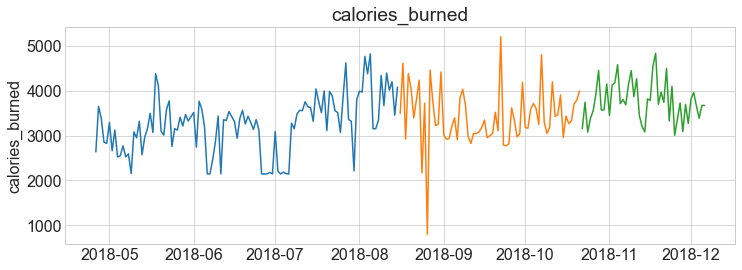

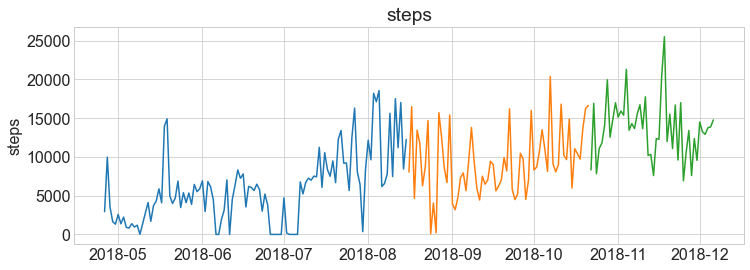

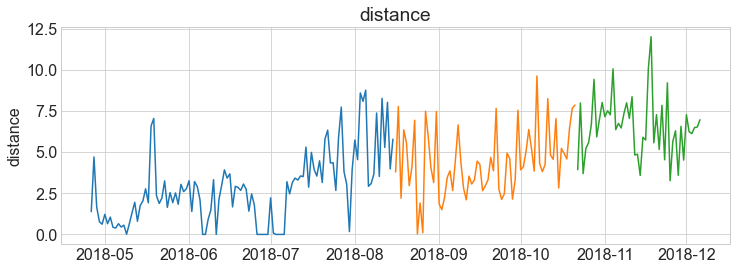

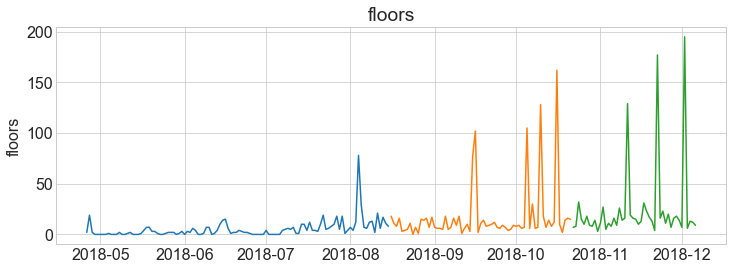

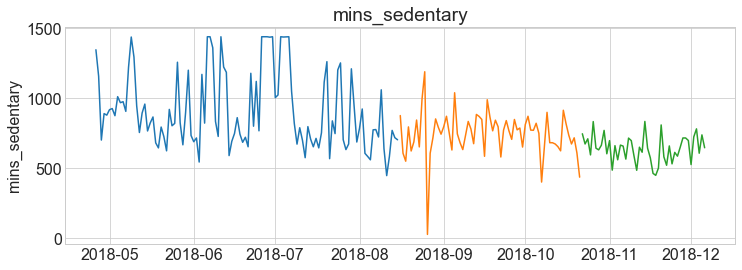

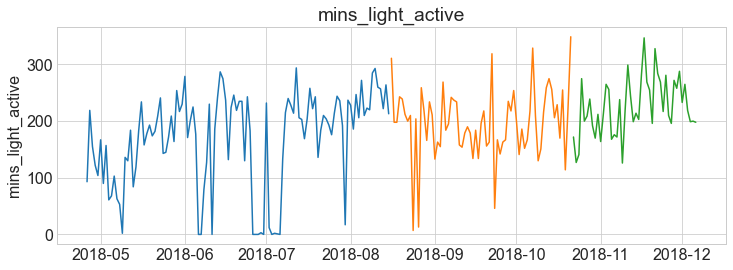

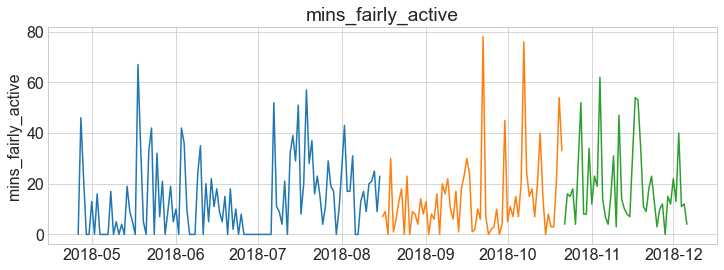

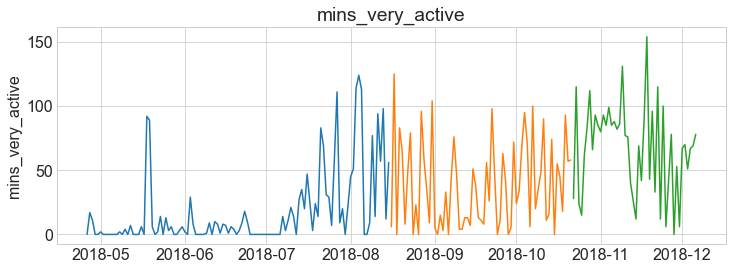

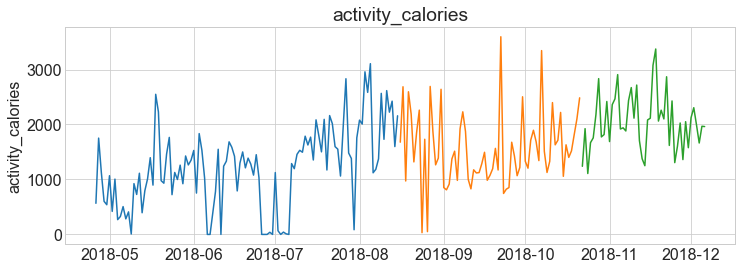

In [18]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### Create Evaluate Functions

In [19]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [20]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [21]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [22]:
# Verify Functions Work Properly
eval_df

Empty DataFrame
Columns: [model_type, target_var, rmse]
Index: []

<div class="alert alert-block alert-info"><b></b></div>

# Forecast

Forecasting is another word for predicting time series data.

    Last Observed Value
    Simple Average
    Moving Average
    Holt's Linear Trend
    Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

## Last Observed Value

<div class="alert alert-block alert-info"><b></b></div>

In [23]:
list = list(train.columns)
list

['calories_burned',
 'steps',
 'distance',
 'floors',
 'mins_sedentary',
 'mins_light_active',
 'mins_fairly_active',
 'mins_very_active',
 'activity_calories']

#### Make Predictions

In [24]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'][-1:][0], 2)
# steps prediction
steps = round(train['steps'][-1:][0], 2)
# distance prediction
distance = round(train['distance'][-1:][0], 2)
# floors prediction
floors = round(train['floors'][-1:][0], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'][-1:][0], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'][-1:][0], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'][-1:][0], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'][-1:][0], 2)
# activity_calories
activity_calories = round(train['activity_calories'][-1:][0], 2)

#### Apply Predictions to Observations

In [25]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

calories_burned    steps  distance  floors  mins_sedentary  \
date                                                                     
2018-08-16           4079.0  12259.0      5.78     8.0           704.0   
2018-08-17           4079.0  12259.0      5.78     8.0           704.0   
2018-08-18           4079.0  12259.0      5.78     8.0           704.0   
2018-08-19           4079.0  12259.0      5.78     8.0           704.0   
2018-08-20           4079.0  12259.0      5.78     8.0           704.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-08-16              213.0                23.0              56.0   
2018-08-17              213.0                23.0              56.0   
2018-08-18              213.0                23.0              56.0   
2018-08-19              213.0                23.0              56.0   
2018-08-20              213.0                23.0              56.0   

            activity_calories  
date                           
2018-08-16             2158.0  
2018-08-17             2158.0  
2018-08-18             2158.0  
2018-08-19             2158.0  
2018-08-20             2158.0

#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 921


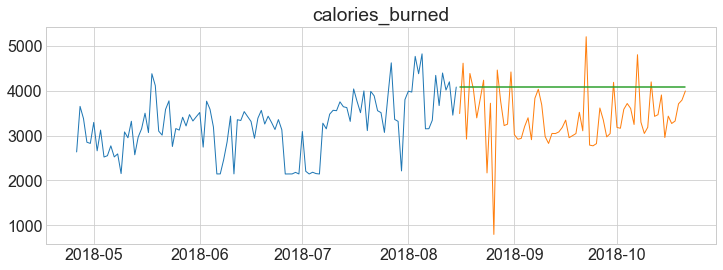

steps -- RMSE: 5156


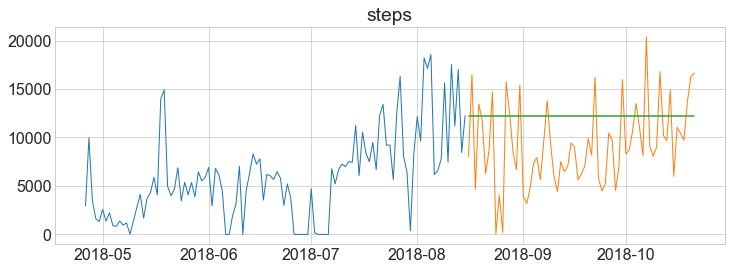

distance -- RMSE: 2


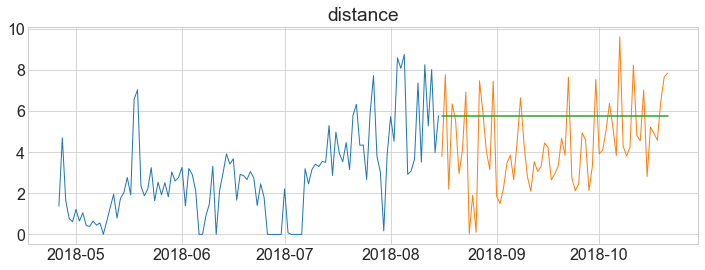

floors -- RMSE: 31


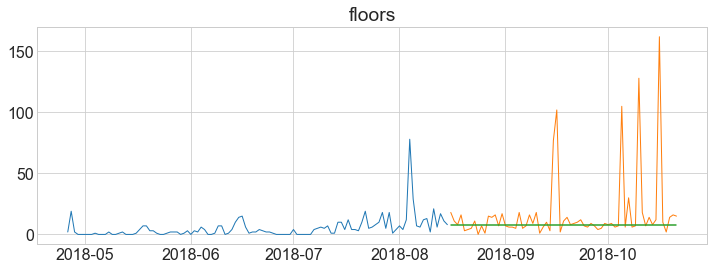

mins_sedentary -- RMSE: 163


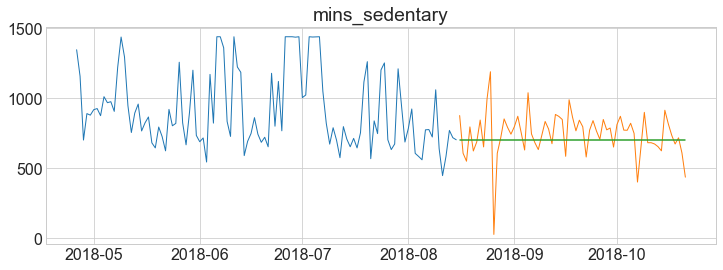

mins_light_active -- RMSE: 64


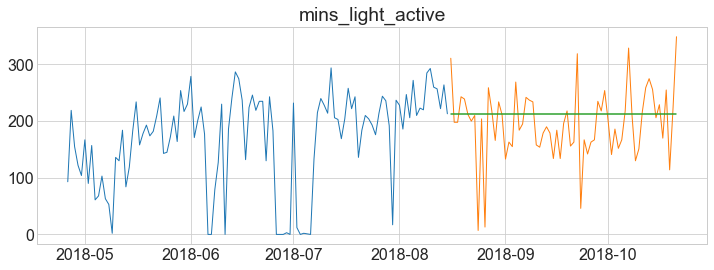

mins_fairly_active -- RMSE: 18


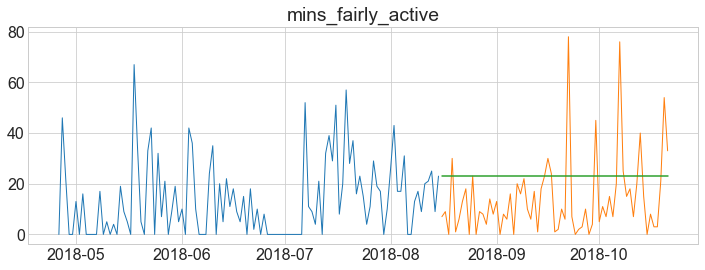

mins_very_active -- RMSE: 38


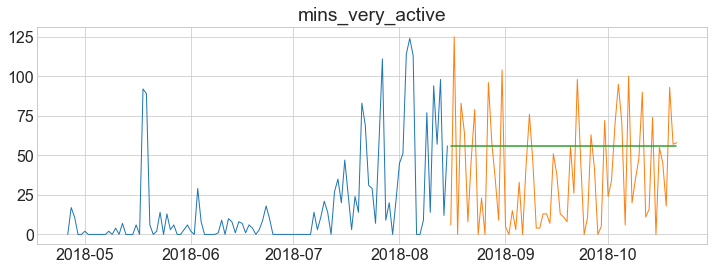

activity_calories -- RMSE: 897


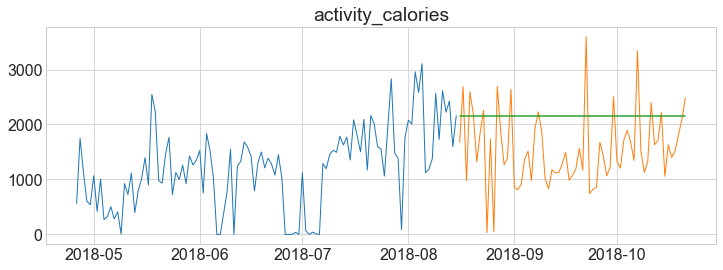

In [26]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

model_type          target_var    rmse
0  last_observed_value     calories_burned   921.0
1  last_observed_value               steps  5156.0
2  last_observed_value            distance     2.0
3  last_observed_value              floors    31.0
4  last_observed_value      mins_sedentary   163.0
5  last_observed_value   mins_light_active    64.0
6  last_observed_value  mins_fairly_active    18.0
7  last_observed_value    mins_very_active    38.0
8  last_observed_value   activity_calories   897.0

***

**Takeaway:**

`The last vale in Train just happened to be a day where this individual stopped their regular pattern of behavior.  RMSE is very hight, average line is far from validate, model demonstrate low perdictive value`

***

<div class="alert alert-block alert-info"><b></b></div>

## Simple Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [28]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'].mean(), 2)
# steps prediction
steps = round(train['steps'].mean(), 2)
# distance prediction
distance = round(train['distance'].mean(), 2)
# floors prediction
floors = round(train['floors'].mean(), 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].mean(), 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].mean(), 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].mean(), 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].mean(), 2)
# activity_calories
activity_calories = round(train['activity_calories'].mean(), 2)

#### Apply Predictions to Observations

In [29]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

calories_burned    steps  distance  floors  mins_sedentary  \
date                                                                     
2018-08-16           3246.8  5962.52      2.81    5.18          916.93   
2018-08-17           3246.8  5962.52      2.81    5.18          916.93   
2018-08-18           3246.8  5962.52      2.81    5.18          916.93   
2018-08-19           3246.8  5962.52      2.81    5.18          916.93   
2018-08-20           3246.8  5962.52      2.81    5.18          916.93   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-08-16             168.45               13.78             17.66   
2018-08-17             168.45               13.78             17.66   
2018-08-18             168.45               13.78             17.66   
2018-08-19             168.45               13.78             17.66   
2018-08-20             168.45               13.78             17.66   

            activity_calories  
date                           
2018-08-16            1212.98  
2018-08-17            1212.98  
2018-08-18            1212.98  
2018-08-19            1212.98  
2018-08-20            1212.98

#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 658


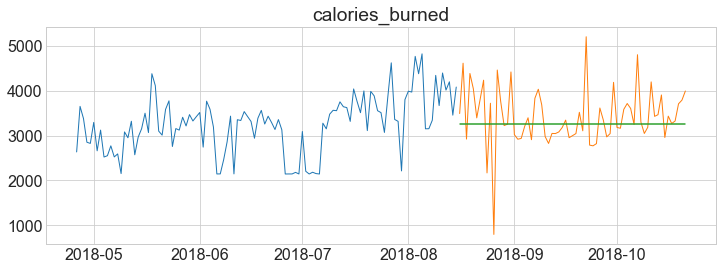

steps -- RMSE: 5356


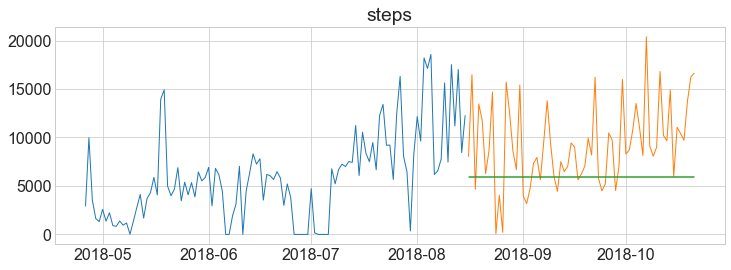

distance -- RMSE: 3


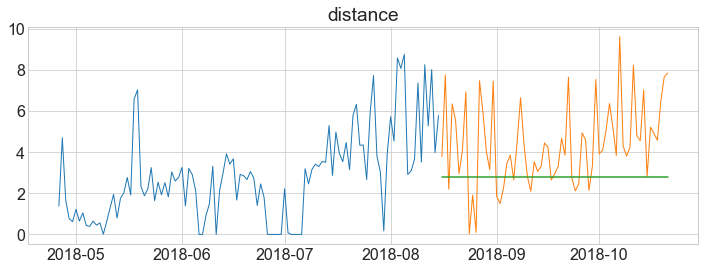

floors -- RMSE: 32


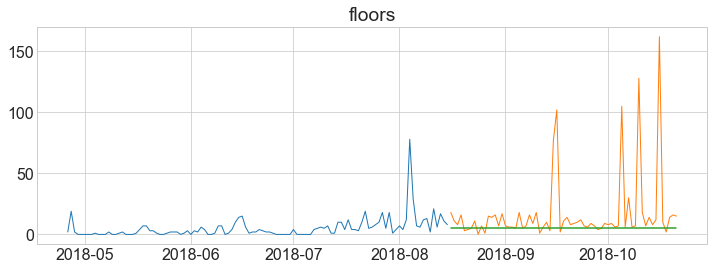

mins_sedentary -- RMSE: 233


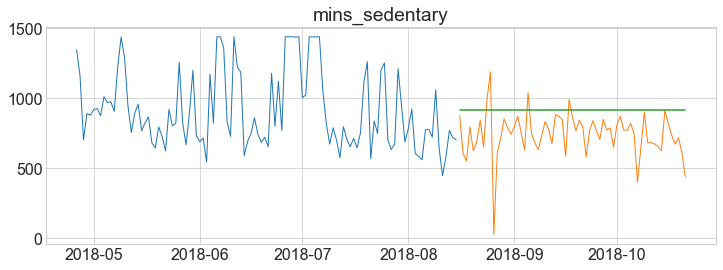

mins_light_active -- RMSE: 68


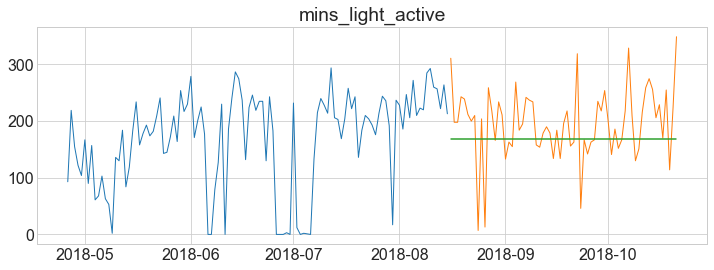

mins_fairly_active -- RMSE: 16


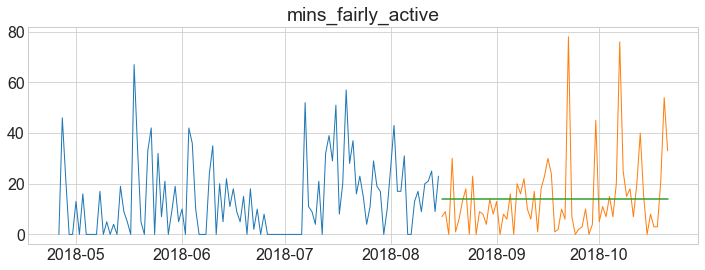

mins_very_active -- RMSE: 39


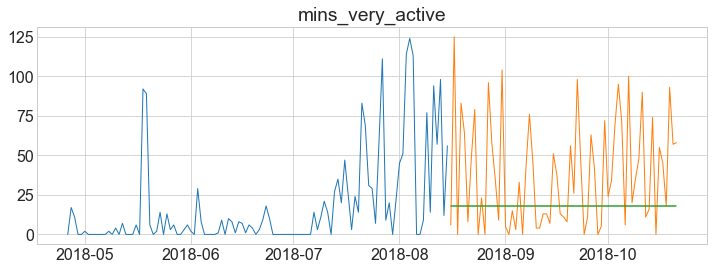

activity_calories -- RMSE: 746


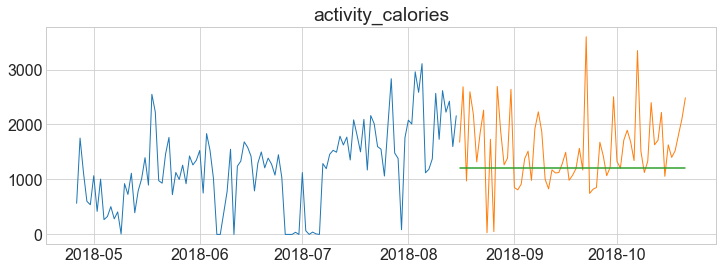

In [30]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [31]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df.sort_values('rmse')

model_type          target_var    rmse
2   last_observed_value            distance     2.0
11       simple_average            distance     3.0
15       simple_average  mins_fairly_active    16.0
6   last_observed_value  mins_fairly_active    18.0
3   last_observed_value              floors    31.0
12       simple_average              floors    32.0
7   last_observed_value    mins_very_active    38.0
16       simple_average    mins_very_active    39.0
5   last_observed_value   mins_light_active    64.0
14       simple_average   mins_light_active    68.0
4   last_observed_value      mins_sedentary   163.0
13       simple_average      mins_sedentary   233.0
9        simple_average     calories_burned   658.0
17       simple_average   activity_calories   746.0
8   last_observed_value   activity_calories   897.0
0   last_observed_value     calories_burned   921.0
1   last_observed_value               steps  5156.0
10       simple_average               steps  5356.0

***

**Takeaway:**

`Simple average has lower RMSE than last observed value. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Moving Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [32]:
# 30 Day Rolling average (notice monthly seasonality)

period = 30 

# calories_burned Prediction
calories_burned  = round(train['calories_burned'].rolling(period).mean()[-1], 2)
# steps prediction
steps = round(train['steps'].rolling(period).mean()[-1], 2)
# distance prediction
distance = round(train['distance'].rolling(period).mean()[-1], 2)
# floors prediction
floors = round(train['floors'].rolling(period).mean()[-1], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].rolling(period).mean()[-1], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].rolling(period).mean()[-1], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].rolling(period).mean()[-1], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].rolling(period).mean()[-1], 2)
# activity_calories
activity_calories = round(train['activity_calories'].rolling(period).mean()[-1], 2)

#### Apply Predictions to Observations

In [33]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

calories_burned     steps  distance  floors  mins_sedentary  \
date                                                                      
2018-08-16          3774.33  10650.63      5.02    12.0           797.2   
2018-08-17          3774.33  10650.63      5.02    12.0           797.2   
2018-08-18          3774.33  10650.63      5.02    12.0           797.2   
2018-08-19          3774.33  10650.63      5.02    12.0           797.2   
2018-08-20          3774.33  10650.63      5.02    12.0           797.2   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-08-16              218.4               18.83             45.63   
2018-08-17              218.4               18.83             45.63   
2018-08-18              218.4               18.83             45.63   
2018-08-19              218.4               18.83             45.63   
2018-08-20              218.4               18.83             45.63   

            activity_calories  
date                           
2018-08-16            1872.93  
2018-08-17            1872.93  
2018-08-18            1872.93  
2018-08-19            1872.93  
2018-08-20            1872.93

#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 732


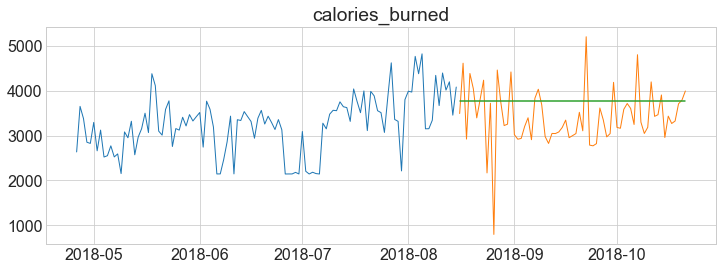

steps -- RMSE: 4425


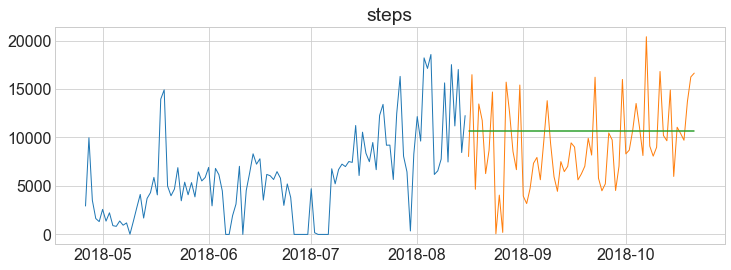

distance -- RMSE: 2


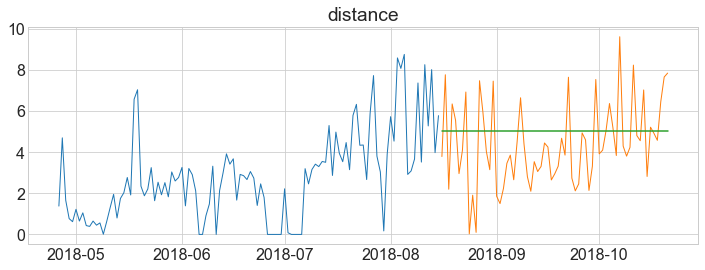

floors -- RMSE: 30


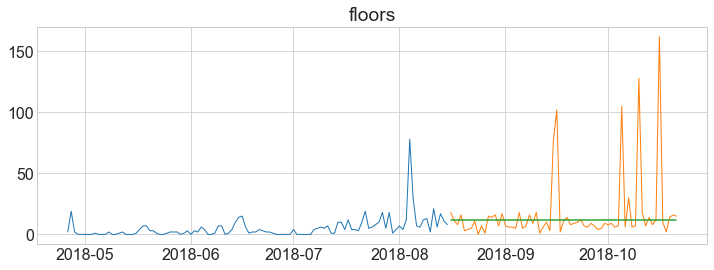

mins_sedentary -- RMSE: 166


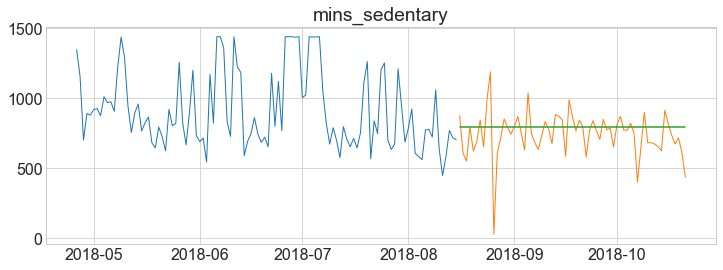

mins_light_active -- RMSE: 66


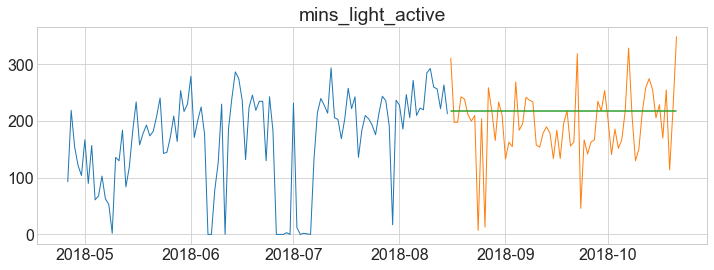

mins_fairly_active -- RMSE: 16


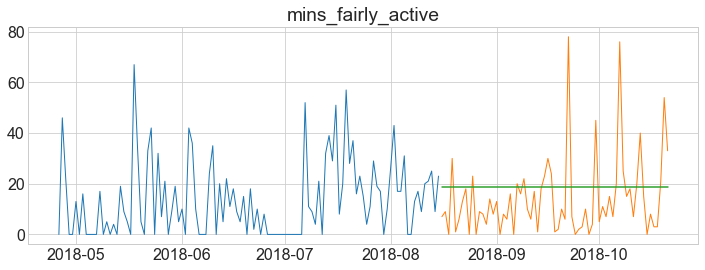

mins_very_active -- RMSE: 34


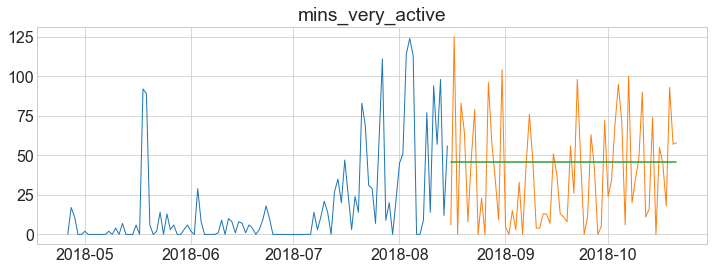

activity_calories -- RMSE: 736


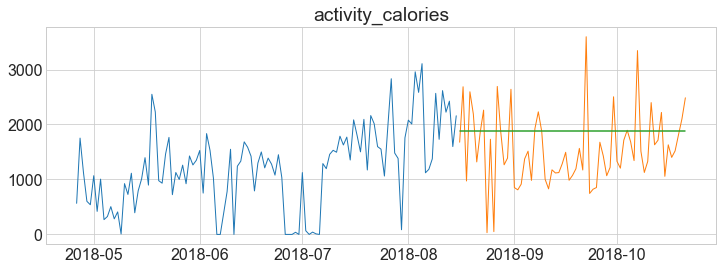

In [34]:
for col in train.columns:
    plot_and_eval(col)

#### Additional Rolling Averages (To Try)

In [35]:
periods = [1, 7, 12, 26, 52, 104]

for p in periods:
    calories_burned  = round(train['calories_burned'].rolling(period).mean()[-1], 2)
    steps = round(train['steps'].rolling(period).mean()[-1], 2)
    distance = round(train['distance'].rolling(period).mean()[-1], 2)
    floors = round(train['floors'].rolling(period).mean()[-1], 2)
    mins_sedentary = round(train['mins_sedentary'].rolling(period).mean()[-1], 2)
    mins_light_active = round(train['mins_light_active'].rolling(period).mean()[-1], 2)
    mins_fairly_active = round(train['mins_fairly_active'].rolling(period).mean()[-1], 2)
    mins_very_active = round(train['mins_very_active'].rolling(period).mean()[-1], 2)
    activity_calories = round(train['activity_calories'].rolling(period).mean()[-1], 2)
    model_type = str(p) + 'd moving average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

#### Evauate

In [36]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df.sort_values('rmse')

model_type target_var    rmse
20    1d moving average   distance     2.0
56   52d moving average   distance     2.0
2   last_observed_value   distance     2.0
47   26d moving average   distance     2.0
65  104d moving average   distance     2.0
..                  ...        ...     ...
55   52d moving average      steps  4425.0
28    7d moving average      steps  4425.0
64  104d moving average      steps  4425.0
1   last_observed_value      steps  5156.0
10       simple_average      steps  5356.0

[81 rows x 3 columns]

***

**Takeaway:**

`7 Day moving average has lower RMSE than simple average. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Holt's Linear Trend

<div class="alert alert-block alert-info"><b></b></div>


#### Seasonal Decomposition

`First, let's take a look at the seasonal decomposition for each target.`


calories_burned 



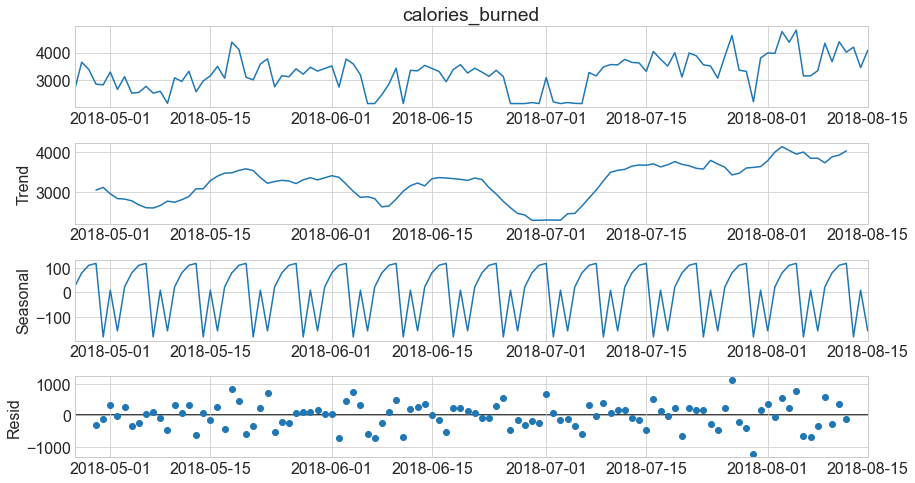

steps 



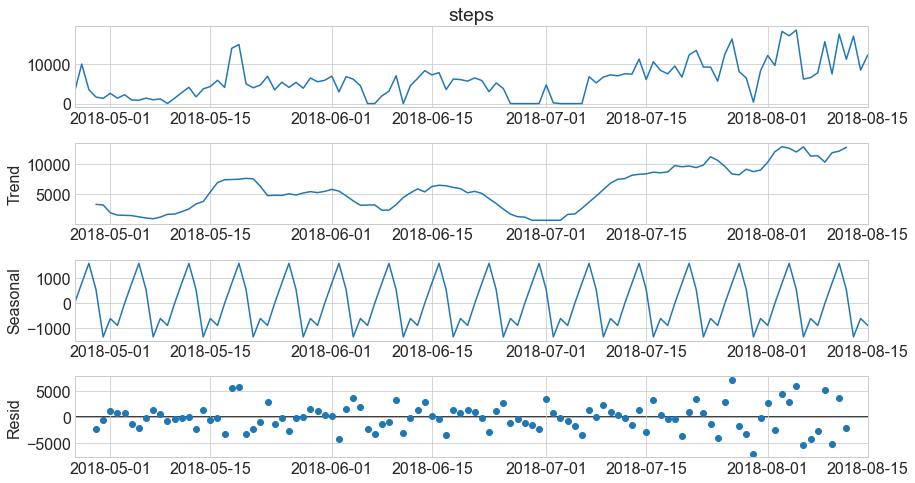

distance 



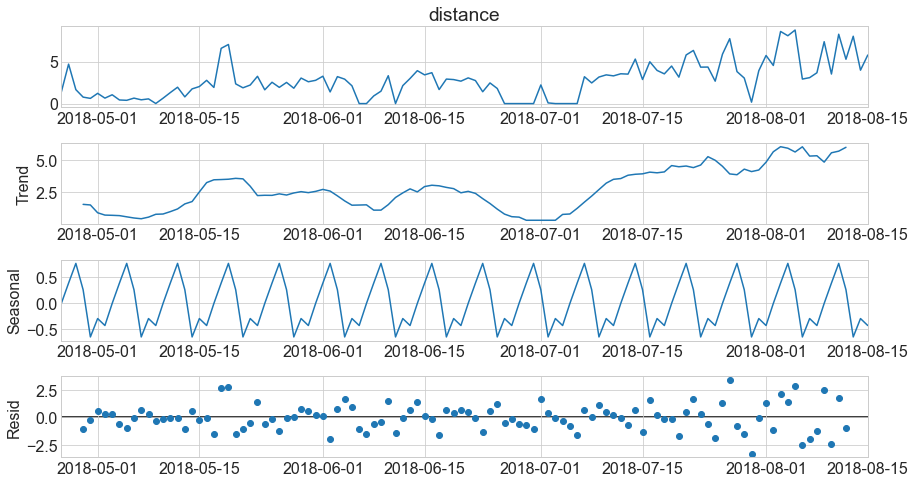

floors 



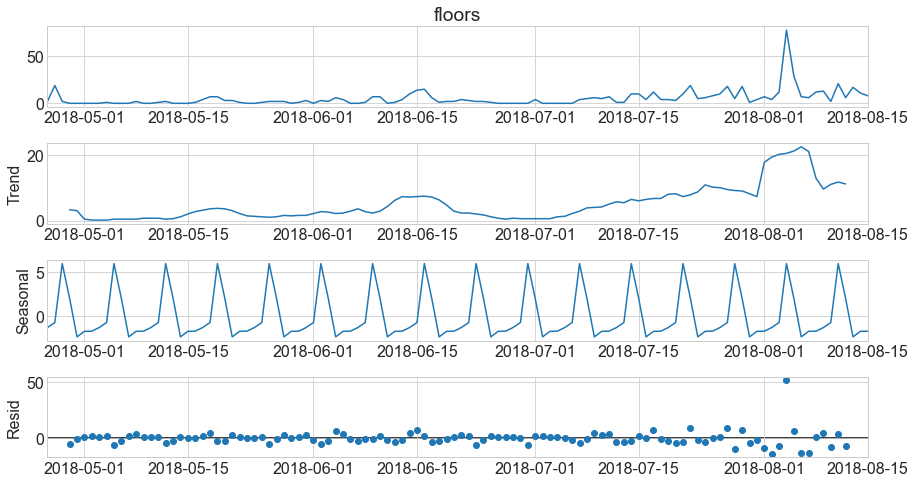

mins_sedentary 



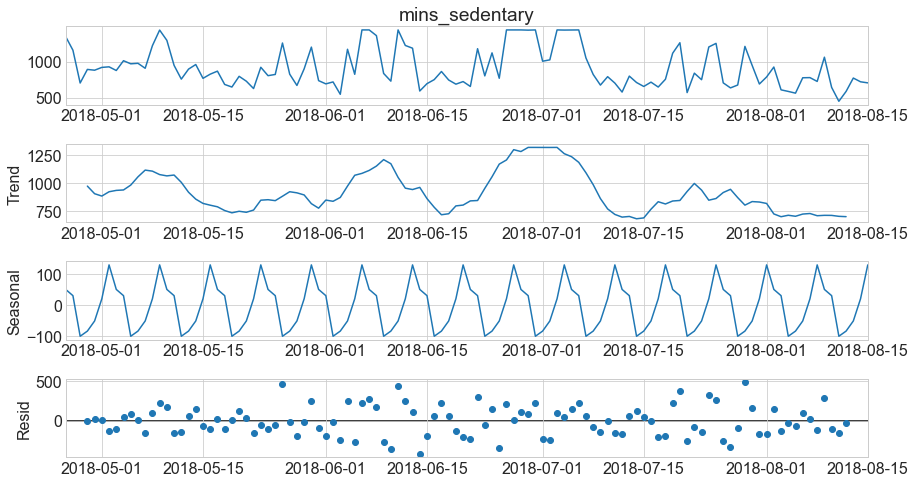

mins_light_active 



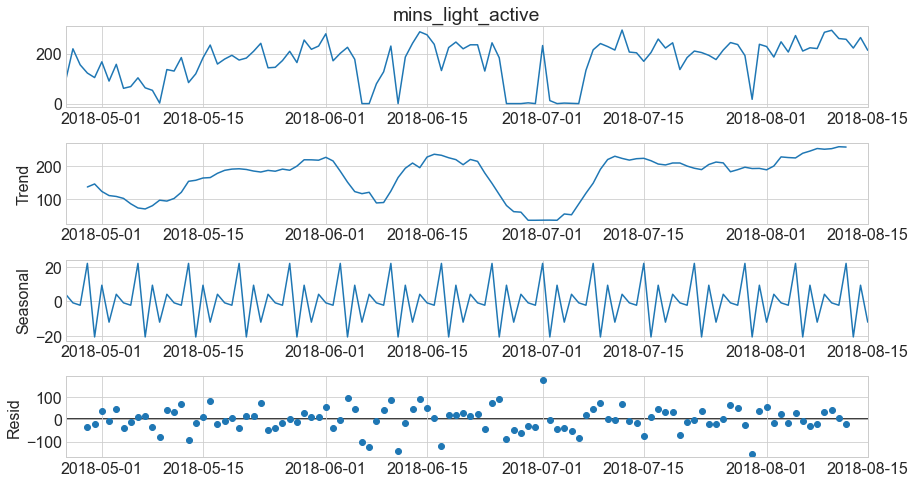

mins_fairly_active 



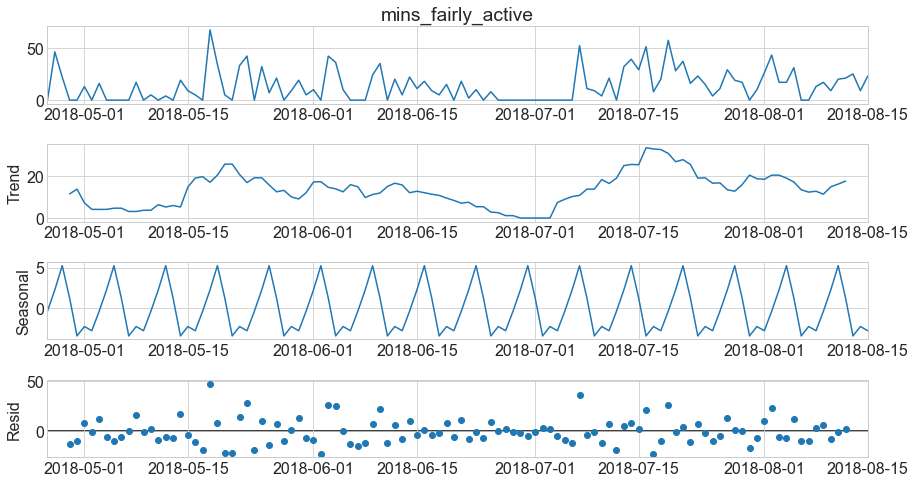

mins_very_active 



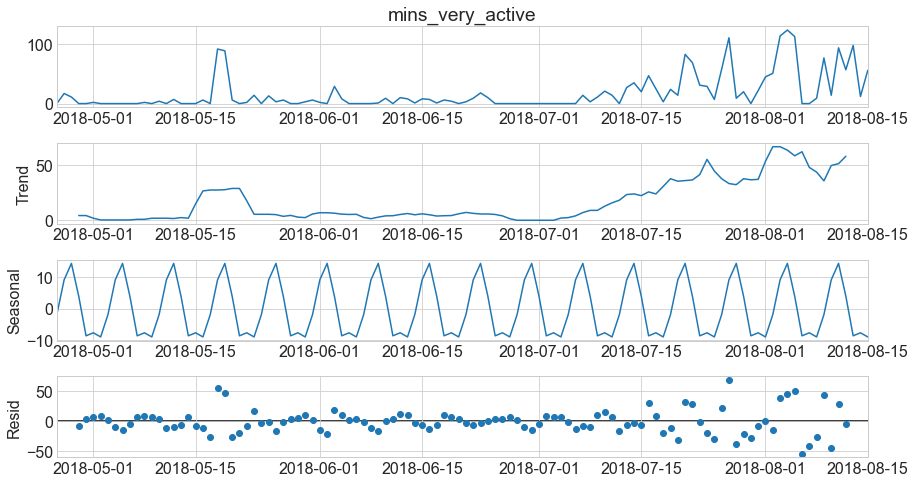

activity_calories 



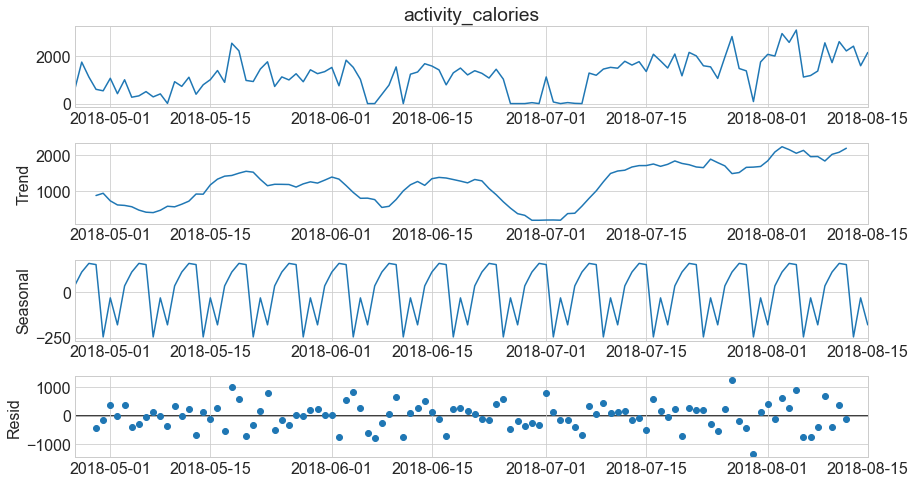

In [37]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('D').mean()).plot()
    plt.show()

#### Make Predictions and Apply to Observations

In [38]:
for col in train.columns:
    model = Holt(train[col], exponential = False, damped=True)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [39]:
yhat_df.head()

calories_burned     steps  distance  floors  mins_sedentary  \
date                                                                      
2018-08-16          4070.95  13271.04      5.58   13.17          658.63   
2018-08-17          4082.58  13394.04      5.60   13.10          651.68   
2018-08-18          4094.08  13515.80      5.61   13.05          644.80   
2018-08-19          4105.48  13636.35      5.61   13.01          637.98   
2018-08-20          4116.75  13755.70      5.62   12.98          631.24   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-08-16             257.02               16.91             56.77   
2018-08-17             259.14               16.92             57.09   
2018-08-18             261.25               16.94             57.39   
2018-08-19             263.33               16.95             57.68   
2018-08-20             265.39               16.96             57.94   

            activity_calories  
date                           
2018-08-16            2235.35  
2018-08-17            2250.92  
2018-08-18            2266.35  
2018-08-19            2281.62  
2018-08-20            2296.73

#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 1170


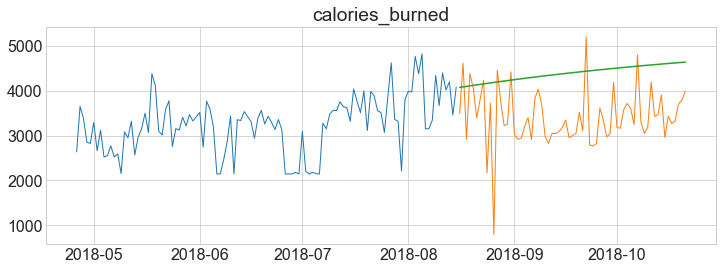

steps -- RMSE: 8370


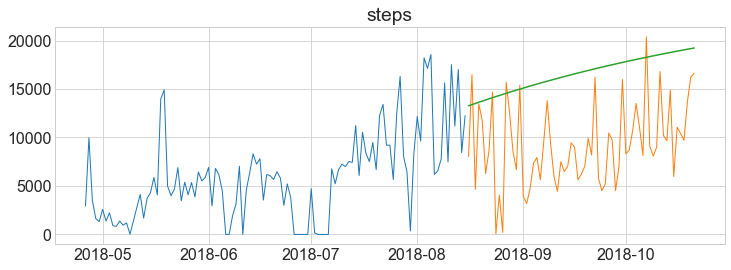

distance -- RMSE: 2


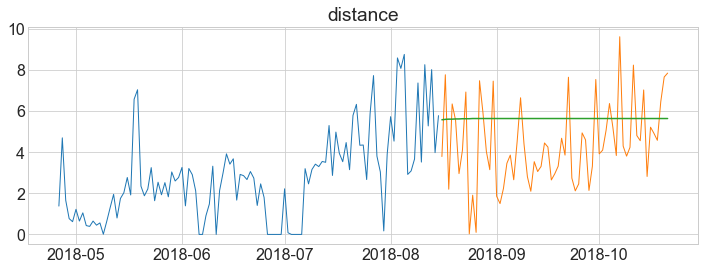

floors -- RMSE: 30


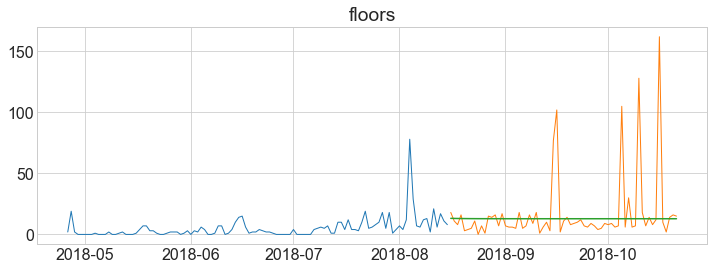

mins_sedentary -- RMSE: 328


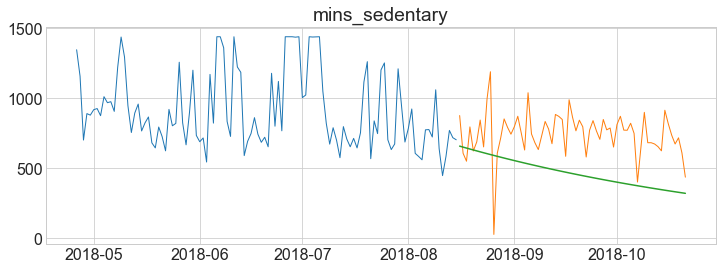

mins_light_active -- RMSE: 135


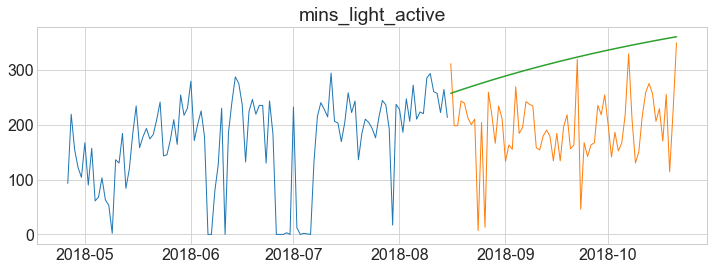

mins_fairly_active -- RMSE: 16


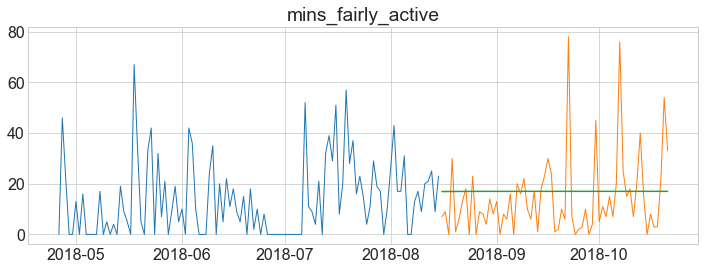

mins_very_active -- RMSE: 40


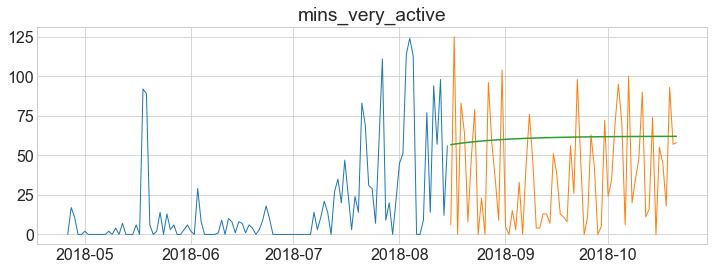

activity_calories -- RMSE: 1296


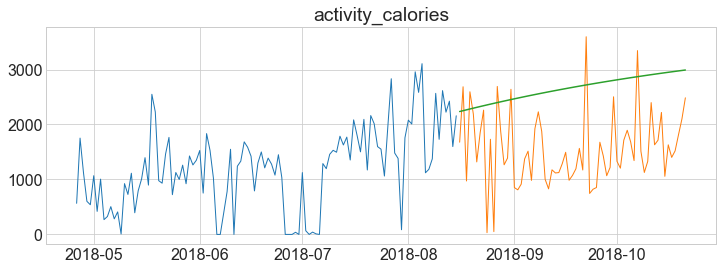

In [40]:
for col in train.columns:
    plot_and_eval(target_var = col)

#### Evauate

In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

eval_df.sort_values('rmse')

model_type target_var    rmse
38   12d moving average   distance     2.0
47   26d moving average   distance     2.0
56   52d moving average   distance     2.0
83                Holts   distance     2.0
29    7d moving average   distance     2.0
..                  ...        ...     ...
19    1d moving average      steps  4425.0
73       30d_moving_avg      steps  4425.0
1   last_observed_value      steps  5156.0
10       simple_average      steps  5356.0
82                Holts      steps  8370.0

[90 rows x 3 columns]

***

**Takeaway:**

`Model does not do a great job predicting trends and seasonality`

***

<div class="alert alert-block alert-info"><b></b></div>

## Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

### Resame Data w/7  Days Splits 

#### Make Predictions

In [42]:
train = df[:'2018-11-22']
validate = df.loc['2018-11-23':'2018-11-29']
test = df.loc['2018-11-30':'2018-12-06']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(211, 9)
(7, 9)
(7, 9)


calories_burned   steps  distance  floors  mins_sedentary  \
date                                                                    
2018-04-26           2635.0  2931.0      1.38     2.0          1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0          1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0           702.0   
2018-04-29           2851.0  1639.0      0.77     0.0           891.0   
2018-04-30           2825.0  1323.0      0.62     0.0           880.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-04-26               93.0                 0.0               0.0   
2018-04-27              219.0                46.0              17.0   
2018-04-28              155.0                22.0              11.0   
2018-04-29              122.0                 0.0               0.0   
2018-04-30              104.0                 0.0               0.0   

            activity_calories  
date                           
2018-04-26              566.0  
2018-04-27             1752.0  
2018-04-28             1124.0  
2018-04-29              602.0  
2018-04-30              540.0

In [43]:
train.tail(1)

calories_burned    steps  distance  floors  mins_sedentary  \
date                                                                     
2018-11-22           4494.0  16705.0      7.84   177.0           522.0   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-11-22              284.0                18.0             115.0   

            activity_calories  
date                           
2018-11-22             2868.0

#### Apply Predictions to Observations

In [44]:
yhat_df = train['2018-11-16':'2018-11-22'] + train.diff(7).mean()

In [45]:
pd.concat([yhat_df.head(1), validate.head(1)])

calories_burned         steps  distance  floors  mins_sedentary  \
date                                                                          
2018-11-16      3818.058824  12727.955882  5.938922   14.25      561.696078   
2018-11-23      3325.000000   9602.000000  4.530000   16.00      660.000000   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-11-16          285.95098           31.632353         44.661765   
2018-11-23          269.00000           23.000000         12.000000   

            activity_calories  
date                           
2018-11-16        2171.764706  
2018-11-23        1619.000000

In [46]:
# set yhat_df to index of validate

yhat_df.index = validate.index

yhat_df.describe()

calories_burned         steps   distance      floors  mins_sedentary  \
count         7.000000      7.000000   7.000000    7.000000        7.000000   
mean       4188.773109  16655.813025   7.868922   40.964286      543.696078   
std         463.243893   5232.285429   2.554897   61.130228      122.021856   
min        3735.058824  11520.955882   5.368922    5.250000      435.696078   
25%        3797.058824  12581.455882   5.853922   14.250000      468.696078   
50%        4004.058824  15968.955882   7.478922   18.250000      507.696078   
75%        4559.058824  18991.955882   9.158922   28.250000      564.696078   
max        4870.058824  25953.955882  12.208922  178.250000      795.696078   

       mins_light_active  mins_fairly_active  mins_very_active  \
count           7.000000            7.000000          7.000000   
mean          284.950980           30.632353         84.518908   
std            49.349097           18.565200         44.823463   
min           200.950980            9.632353         35.661765   
25%           266.950980           15.132353         45.161765   
50%           285.950980           31.632353         92.661765   
75%           310.950980           44.132353        108.161765   
max           351.950980           54.632353        156.661765   

       activity_calories  
count           7.000000  
mean         2608.478992  
std           543.157348  
min          2119.764706  
25%          2165.264706  
50%          2317.764706  
75%          3030.264706  
max          3430.764706

#### Plot and Evaluate

calories_burned -- RMSE: 874


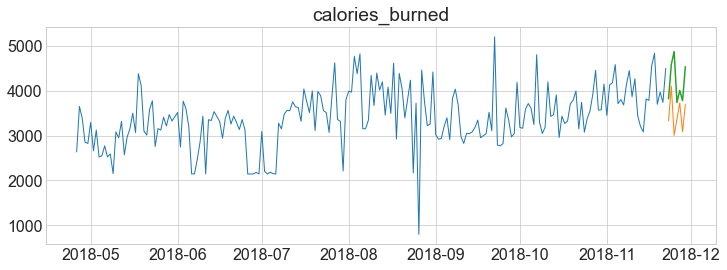

steps -- RMSE: 7881


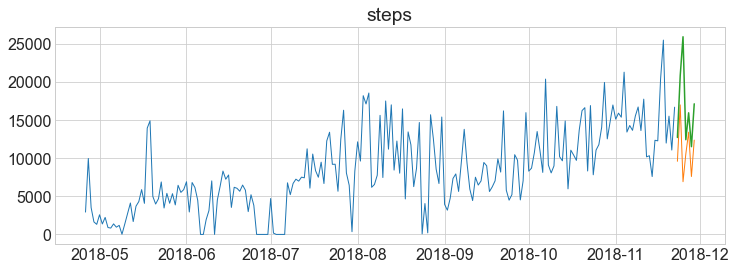

distance -- RMSE: 4


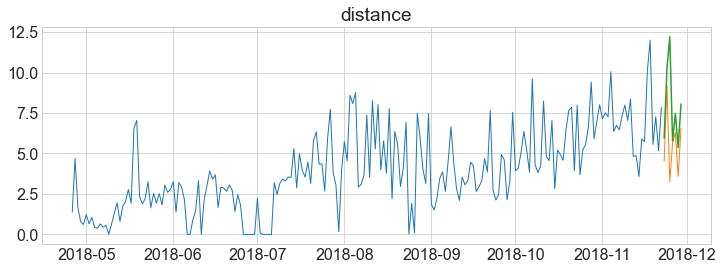

floors -- RMSE: 61


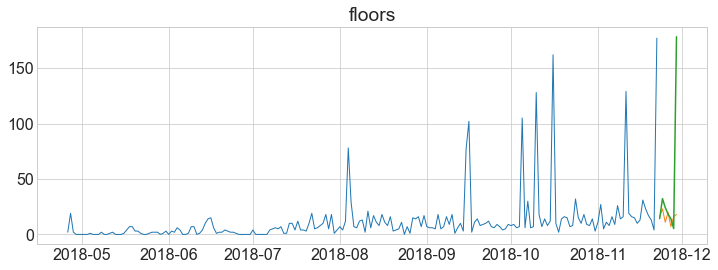

mins_sedentary -- RMSE: 144


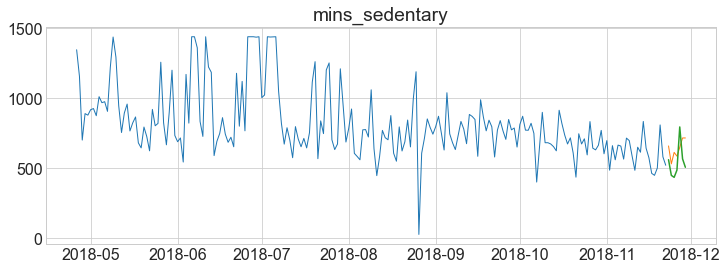

mins_light_active -- RMSE: 61


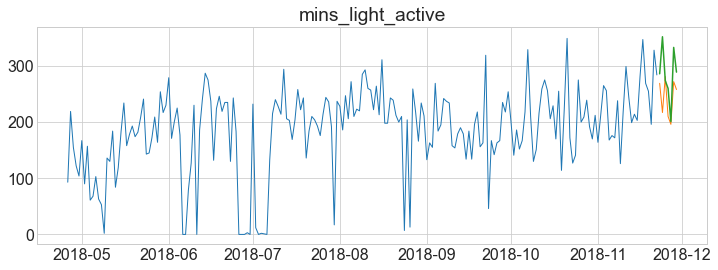

mins_fairly_active -- RMSE: 27


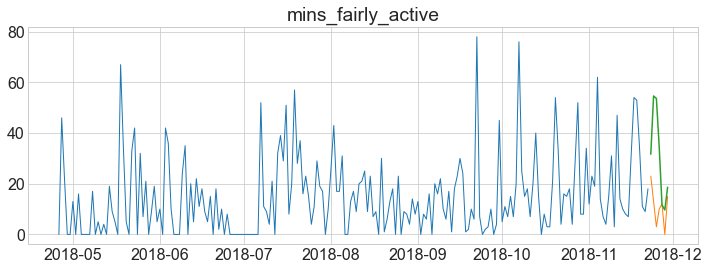

mins_very_active -- RMSE: 65


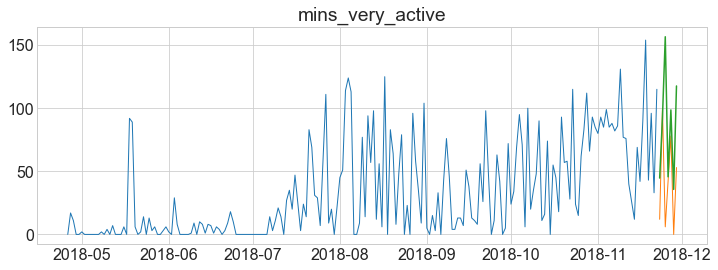

activity_calories -- RMSE: 1005


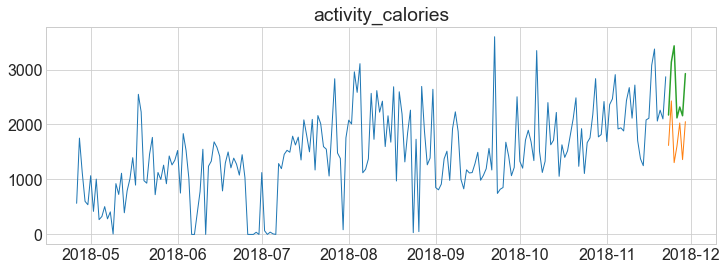

In [47]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_cycle", 
                            target_var = col)

<div class="alert alert-block alert-info"><b></b></div>

## Model Evaluation (Train):

<div class="alert alert-block alert-info"><b></b></div>

#### Which model did the best?

In [48]:

# calories_burned_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]
# steps_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]
# distance_min_rmse = eval_df.groupby('target_var')['rmse'].min()[2]
# floors_min_rmse = eval_df.groupby('target_var')['rmse'].min()[3]
# mins_sedentary_min_rmse = eval_df.groupby('target_var')['rmse'].min()[4]
# mins_light_active_min_rmse = eval_df.groupby('target_var')['rmse'].min()[5]
# mins_fairly_active_min_rmse = eval_df.groupby('target_var')['rmse'].min()[6]
# mins_very_active_min_rmse = eval_df.groupby('target_var')['rmse'].min()[7]
# activity_calories_min_rmse = eval_df.groupby('target_var')['rmse'].min()[8]

# # find which model that is
# eval_df[((eval_df.rmse == calories_burned_min_rmse) | 
#          (eval_df.rmse == steps_min_rmse) |
#          (eval_df.rmse == distance_min_rmse) |
#          (eval_df.rmse == floors_min_rmse) |
#          (eval_df.rmse == mins_sedentary_min_rmse) |
#          (eval_df.rmse == mins_light_active_min_rmse ) |
#          (eval_df.rmse == mins_fairly_active_min_rmse) |
#          (eval_df.rmse == mins_very_active_min_rmse) |
#          (eval_df.rmse == activity_calories_min_rmse))]

pd.set_option('display.max_rows', None)
eval_df.groupby(['target_var', 'model_type'])[['rmse']].min()

rmse
target_var         model_type                 
activity_calories  104d moving average   736.0
                   12d moving average    736.0
                   1d moving average     736.0
                   26d moving average    736.0
                   30d_moving_avg        736.0
                   52d moving average    736.0
                   7d moving average     736.0
                   Holts                1296.0
                   last_observed_value   897.0
                   previous_cycle       1005.0
                   simple_average        746.0
calories_burned    104d moving average   732.0
                   12d moving average    732.0
                   1d moving average     732.0
                   26d moving average    732.0
                   30d_moving_avg        732.0
                   52d moving average    732.0
                   7d moving average     732.0
                   Holts                1170.0
                   last_observed_value   921.0
                   previous_cycle        874.0
                   simple_average        658.0
distance           104d moving average     2.0
                   12d moving average      2.0
                   1d moving average       2.0
                   26d moving average      2.0
                   30d_moving_avg          2.0
                   52d moving average      2.0
                   7d moving average       2.0
                   Holts                   2.0
                   last_observed_value     2.0
                   previous_cycle          4.0
                   simple_average          3.0
floors             104d moving average    30.0
                   12d moving average     30.0
                   1d moving average      30.0
                   26d moving average     30.0
                   30d_moving_avg         30.0
                   52d moving average     30.0
                   7d moving average      30.0
                   Holts                  30.0
                   last_observed_value    31.0
                   previous_cycle         61.0
                   simple_average         32.0
mins_fairly_active 104d moving average    16.0
                   12d moving average     16.0
                   1d moving average      16.0
                   26d moving average     16.0
                   30d_moving_avg         16.0
                   52d moving average     16.0
                   7d moving average      16.0
                   Holts                  16.0
                   last_observed_value    18.0
                   previous_cycle         27.0
                   simple_average         16.0
mins_light_active  104d moving average    66.0
                   12d moving average     66.0
                   1d moving average      66.0
                   26d moving average     66.0
                   30d_moving_avg         66.0
                   52d moving average     66.0
                   7d moving average      66.0
                   Holts                 135.0
                   last_observed_value    64.0
                   previous_cycle         61.0
                   simple_average         68.0
mins_sedentary     104d moving average   166.0
                   12d moving average    166.0
                   1d moving average     166.0
                   26d moving average    166.0
                   30d_moving_avg        166.0
                   52d moving average    166.0
                   7d moving average     166.0
                   Holts                 328.0
                   last_observed_value   163.0
                   previous_cycle        144.0
                   simple_average        233.0
mins_very_active   104d moving average    34.0
                   12d moving average     34.0
                   1d moving average      34.0
                   26d moving average     34.0
                   30d_moving_avg         34.0
                   52d moving average     34.0
                   7d moving average      34.0


<div class="alert alert-block alert-info"><b></b></div>

## Test:

<div class="alert alert-block alert-info"><b></b></div>

In [49]:
# Resample, Not Using Previous Cycle

train_size = int(len(df)*.5)
validate_size = int(len(df)*.3)
test_size = int(len(df) - train_size - validate_size)

train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [50]:
test_eval = pd.DataFrame(eval_df[eval_df.model_type == '7d moving average'])
test_eval

model_type          target_var    rmse
27  7d moving average     calories_burned   732.0
28  7d moving average               steps  4425.0
29  7d moving average            distance     2.0
30  7d moving average              floors    30.0
31  7d moving average      mins_sedentary   166.0
32  7d moving average   mins_light_active    66.0
33  7d moving average  mins_fairly_active    16.0
34  7d moving average    mins_very_active    34.0
35  7d moving average   activity_calories   736.0

#### Make Predictions ( Each feature has a specific model that words best, we will test using specific modeling)

In [51]:
# 7 Day Rolling average (notice monthly seasonality)

period = 7 

# calories_burned Prediction
calories_burned  = round(train['calories_burned'].rolling(period).mean()[-1], 2)
# steps prediction
steps = round(train['steps'].rolling(period).mean()[-1], 2)
# distance prediction
distance = round(train['distance'].rolling(period).mean()[-1], 2)
# floors prediction
floors = round(train['floors'].rolling(period).mean()[-1], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].rolling(period).mean()[-1], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].rolling(period).mean()[-1], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].rolling(period).mean()[-1], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].rolling(period).mean()[-1], 2)
# activity_calories
activity_calories = round(train['activity_calories'].rolling(period).mean()[-1], 2)

#### Apply Predictions to Observations

In [52]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = test.index)

yhat_df.head()

calories_burned     steps  distance  floors  mins_sedentary  \
date                                                                      
2018-10-22          4019.71  12791.14      6.03   11.14          704.14   
2018-10-23          4019.71  12791.14      6.03   11.14          704.14   
2018-10-24          4019.71  12791.14      6.03   11.14          704.14   
2018-10-25          4019.71  12791.14      6.03   11.14          704.14   
2018-10-26          4019.71  12791.14      6.03   11.14          704.14   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-10-22             256.29               17.71             58.29   
2018-10-23             256.29               17.71             58.29   
2018-10-24             256.29               17.71             58.29   
2018-10-25             256.29               17.71             58.29   
2018-10-26             256.29               17.71             58.29   

            activity_calories  
date                           
2018-10-22             2188.0  
2018-10-23             2188.0  
2018-10-24             2188.0  
2018-10-25             2188.0  
2018-10-26             2188.0

In [53]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [54]:

rmse_calories_burned = sqrt(mean_squared_error(test['calories_burned'], 
                                       yhat_df['calories_burned']))

rmse_steps = sqrt(mean_squared_error(test['steps'], 
                                       yhat_df['steps']))

rmse_distance = sqrt(mean_squared_error(test['distance'], 
                                       yhat_df['distance']))

rmse_floors = sqrt(mean_squared_error(test['floors'], 
                                       yhat_df['floors']))

rmse_mins_sedentary = sqrt(mean_squared_error(test['mins_sedentary'], 
                                       yhat_df['mins_sedentary']))

rmse_mins_light_active = sqrt(mean_squared_error(test['mins_light_active'], 
                                       yhat_df['mins_light_active']))

rmse_mins_fairly_active = sqrt(mean_squared_error(test['mins_fairly_active'], 
                                       yhat_df['mins_fairly_active']))

rmse_mins_very_active = sqrt(mean_squared_error(test['mins_very_active'], 
                                       yhat_df['mins_very_active']))

rmse_activity_calories= sqrt(mean_squared_error(test['activity_calories'], 
                                       yhat_df['activity_calories']))


In [55]:
print('rmse_calories_burned: ', rmse_calories_burned)
print('rmse_steps: ', rmse_steps)
print('rmse_distance: ', rmse_distance)
print('rmse_floors: ', rmse_floors)
print('rmse_sedentary: ', rmse_mins_sedentary)
print('rmse_light_active: ', rmse_mins_light_active)
print('rmse_fairly_active: ', rmse_mins_fairly_active)
print('rmse_very_active: ', rmse_mins_very_active)
print('rmse_activity_calories: ', rmse_activity_calories)

rmse_calories_burned:  509.0579139471008
rmse_steps:  3865.73454255631
rmse_distance:  1.8840861006818688
rmse_floors:  41.05121446066672
rmse_sedentary:  113.05150246102725
rmse_light_active:  58.395262724776344
rmse_fairly_active:  15.210957577837847
rmse_very_active:  35.94881282432372
rmse_activity_calories:  522.5449429391738


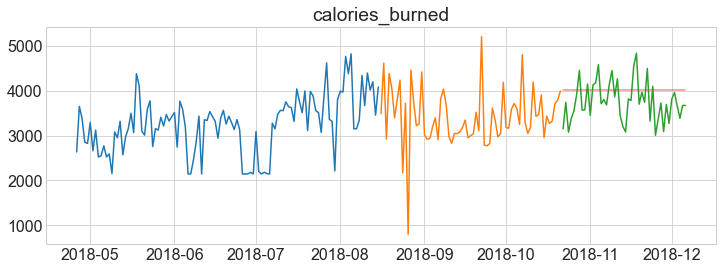

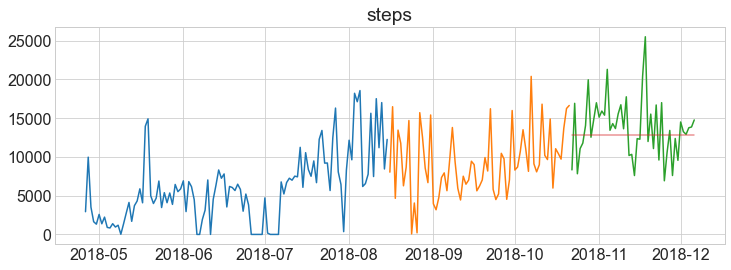

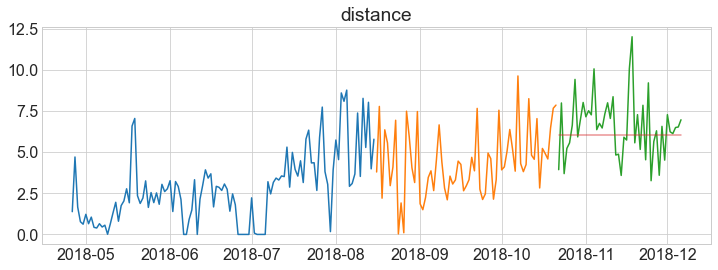

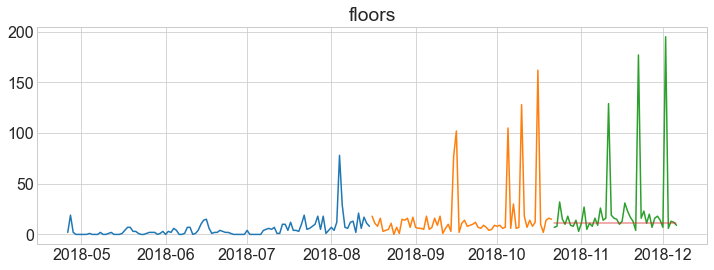

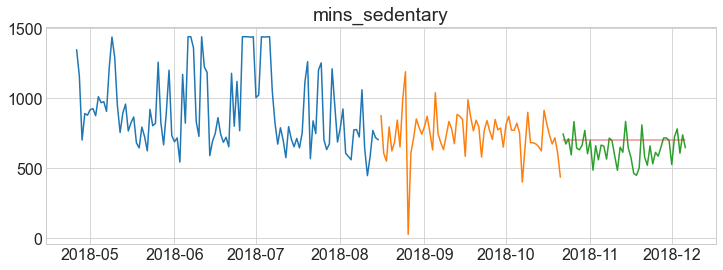

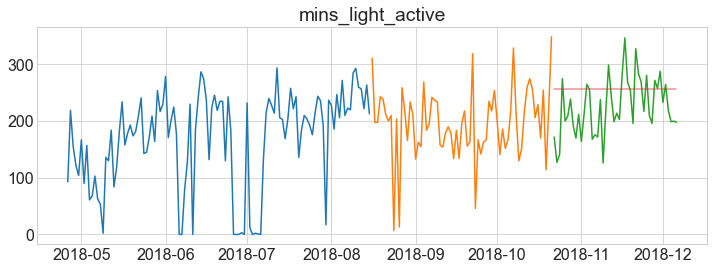

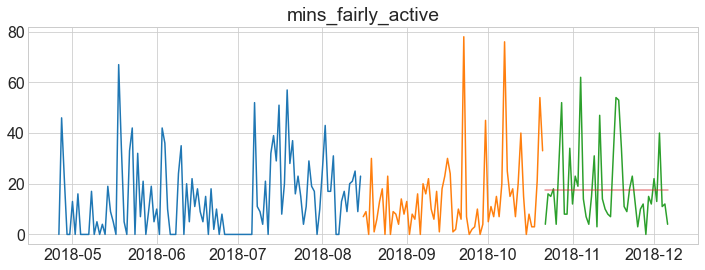

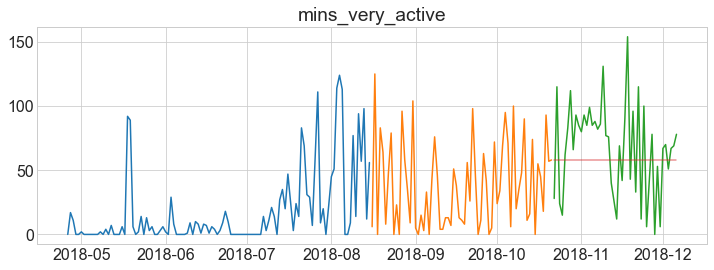

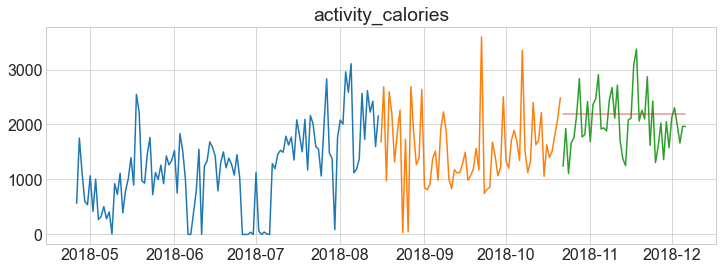

In [56]:
# Visualize
for col in train.columns:
    final_plot(col)

In [57]:
def final_evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    return rmse

In [58]:
# function to store rmse for comparison purposes
def final_append_eval_df(model_type, target_var):
    rmse = final_evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return test_eval.append(d, ignore_index = True)

In [59]:
for col in train.columns:
    test_eval = final_append_eval_df(model_type = '7d test', 
                             target_var = col)

In [60]:
test_eval

model_type          target_var    rmse
0   7d moving average     calories_burned   732.0
1   7d moving average               steps  4425.0
2   7d moving average            distance     2.0
3   7d moving average              floors    30.0
4   7d moving average      mins_sedentary   166.0
5   7d moving average   mins_light_active    66.0
6   7d moving average  mins_fairly_active    16.0
7   7d moving average    mins_very_active    34.0
8   7d moving average   activity_calories   736.0
9             7d test     calories_burned   509.0
10            7d test               steps  3866.0
11            7d test            distance     2.0
12            7d test              floors    41.0
13            7d test      mins_sedentary   113.0
14            7d test   mins_light_active    58.0
15            7d test  mins_fairly_active    15.0
16            7d test    mins_very_active    36.0
17            7d test   activity_calories   523.0

<div class="alert alert-block alert-info"><b></b></div>

## Predict Missing 2 Weeks:

<div class="alert alert-block alert-info"><b></b></div>

In [61]:
yhat_df.index = test.index + pd.Timedelta('2W')

In [62]:
yhat_df

calories_burned     steps  distance  floors  mins_sedentary  \
date                                                                      
2018-11-05          4019.71  12791.14      6.03   11.14          704.14   
2018-11-06          4019.71  12791.14      6.03   11.14          704.14   
2018-11-07          4019.71  12791.14      6.03   11.14          704.14   
2018-11-08          4019.71  12791.14      6.03   11.14          704.14   
2018-11-09          4019.71  12791.14      6.03   11.14          704.14   
2018-11-10          4019.71  12791.14      6.03   11.14          704.14   
2018-11-11          4019.71  12791.14      6.03   11.14          704.14   
2018-11-12          4019.71  12791.14      6.03   11.14          704.14   
2018-11-13          4019.71  12791.14      6.03   11.14          704.14   
2018-11-14          4019.71  12791.14      6.03   11.14          704.14   
2018-11-15          4019.71  12791.14      6.03   11.14          704.14   
2018-11-16          4019.71  12791.14      6.03   11.14          704.14   
2018-11-17          4019.71  12791.14      6.03   11.14          704.14   
2018-11-18          4019.71  12791.14      6.03   11.14          704.14   
2018-11-19          4019.71  12791.14      6.03   11.14          704.14   
2018-11-20          4019.71  12791.14      6.03   11.14          704.14   
2018-11-21          4019.71  12791.14      6.03   11.14          704.14   
2018-11-22          4019.71  12791.14      6.03   11.14          704.14   
2018-11-23          4019.71  12791.14      6.03   11.14          704.14   
2018-11-24          4019.71  12791.14      6.03   11.14          704.14   
2018-11-25          4019.71  12791.14      6.03   11.14          704.14   
2018-11-26          4019.71  12791.14      6.03   11.14          704.14   
2018-11-27          4019.71  12791.14      6.03   11.14          704.14   
2018-11-28          4019.71  12791.14      6.03   11.14          704.14   
2018-11-29          4019.71  12791.14      6.03   11.14          704.14   
2018-11-30          4019.71  12791.14      6.03   11.14          704.14   
2018-12-01          4019.71  12791.14      6.03   11.14          704.14   
2018-12-02          4019.71  12791.14      6.03   11.14          704.14   
2018-12-03          4019.71  12791.14      6.03   11.14          704.14   
2018-12-04          4019.71  12791.14      6.03   11.14          704.14   
2018-12-05          4019.71  12791.14      6.03   11.14          704.14   
2018-12-06          4019.71  12791.14      6.03   11.14          704.14   
2018-12-07          4019.71  12791.14      6.03   11.14          704.14   
2018-12-08          4019.71  12791.14      6.03   11.14          704.14   
2018-12-09          4019.71  12791.14      6.03   11.14          704.14   
2018-12-10          4019.71  12791.14      6.03   11.14          704.14   
2018-12-11          4019.71  12791.14      6.03   11.14          704.14   
2018-12-12          4019.71  12791.14      6.03   11.14          704.14   
2018-12-13          4019.71  12791.14      6.03   11.14          704.14   
2018-12-14          4019.71  12791.14      6.03   11.14          704.14   
2018-12-15          4019.71  12791.14      6.03   11.14          704.14   
2018-12-16          4019.71  12791.14      6.03   11.14          704.14   
2018-12-17          4019.71  12791.14      6.03   11.14          704.14   
2018-12-18          4019.71  12791.14      6.03   11.14          704.14   
2018-12-19          4019.71  12791.14      6.03   11.14          704.14   
2018-12-20          4019.71  12791.14      6.03   11.14          704.14   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-11-05             256.29               17.71             58.29   
2018-11-06             256.29               17.71             58.29   
2018-11-07             256.29               17.71             58.29   
2018-11-08             256.29               17.71       

In [63]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

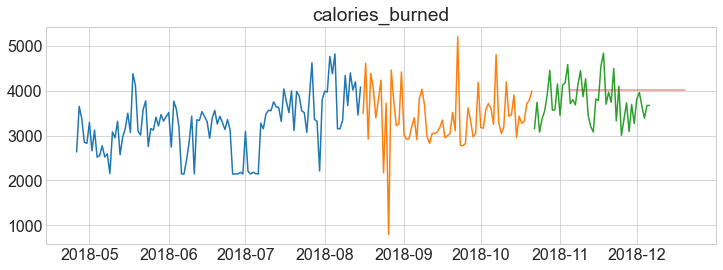

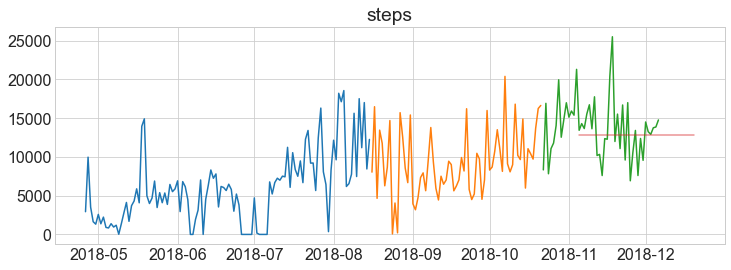

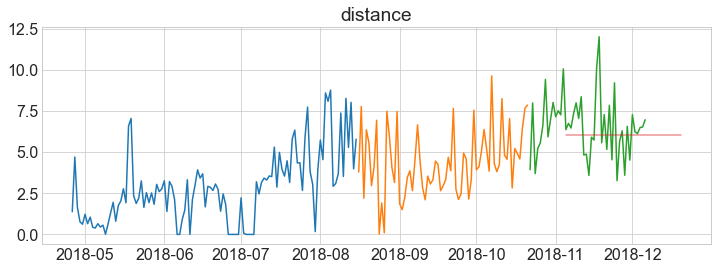

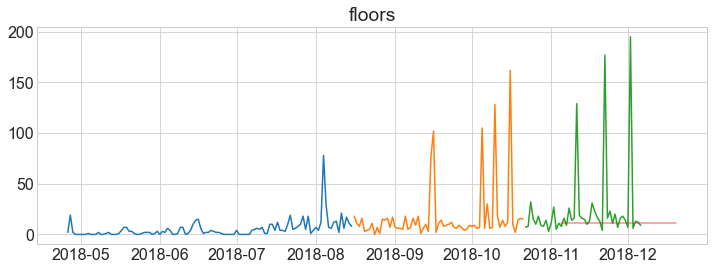

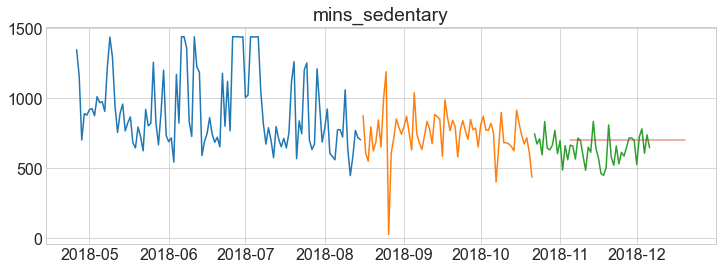

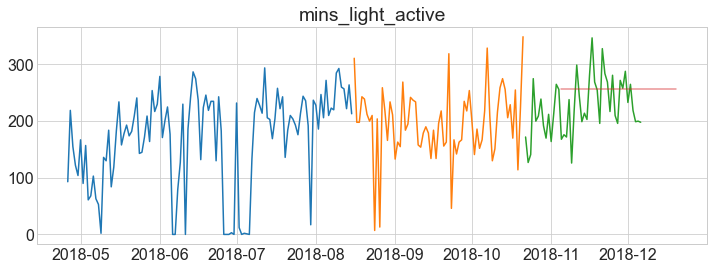

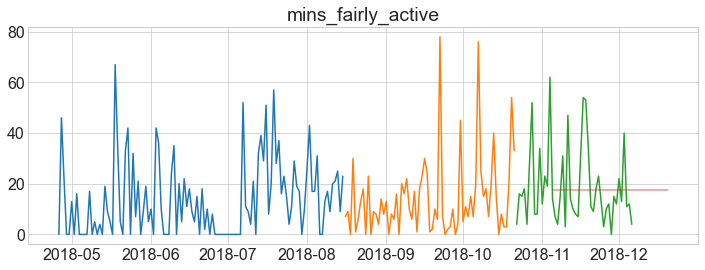

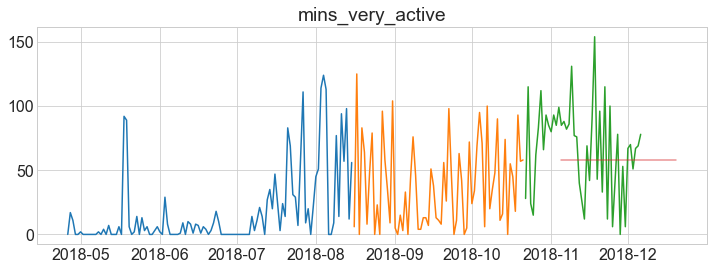

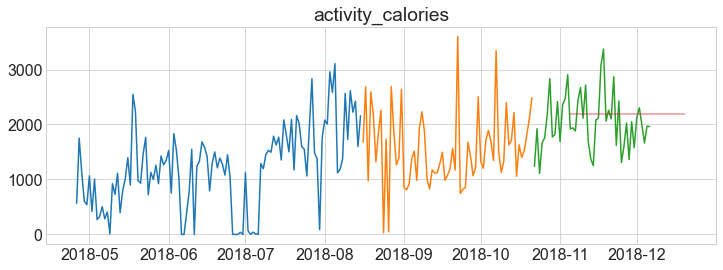

In [64]:
for col in train.columns:
    final_plot(col)

In [65]:
baseline = pd.DataFrame(eval_df[eval_df.model_type == 'last_observed_value'])
baseline

model_type          target_var    rmse
0  last_observed_value     calories_burned   921.0
1  last_observed_value               steps  5156.0
2  last_observed_value            distance     2.0
3  last_observed_value              floors    31.0
4  last_observed_value      mins_sedentary   163.0
5  last_observed_value   mins_light_active    64.0
6  last_observed_value  mins_fairly_active    18.0
7  last_observed_value    mins_very_active    38.0
8  last_observed_value   activity_calories   897.0

In [66]:
test_eval

model_type          target_var    rmse
0   7d moving average     calories_burned   732.0
1   7d moving average               steps  4425.0
2   7d moving average            distance     2.0
3   7d moving average              floors    30.0
4   7d moving average      mins_sedentary   166.0
5   7d moving average   mins_light_active    66.0
6   7d moving average  mins_fairly_active    16.0
7   7d moving average    mins_very_active    34.0
8   7d moving average   activity_calories   736.0
9             7d test     calories_burned   509.0
10            7d test               steps  3866.0
11            7d test            distance     2.0
12            7d test              floors    41.0
13            7d test      mins_sedentary   113.0
14            7d test   mins_light_active    58.0
15            7d test  mins_fairly_active    15.0
16            7d test    mins_very_active    36.0
17            7d test   activity_calories   523.0

In [67]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
base_error = baseline.rmse.sum()
test_error = test_eval[test_eval.model_type =='7d test'].rmse.sum()
difference = (base_error - test_error)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / base_error) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is 29.18%
